# 1. Setup

In [1]:
from mobilkit.umni import SP, F, T
from mobilkit.spark import write as write_spark

from utils import *

## 1.1. Prepare data

In [2]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/03 10:38:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/03 10:38:49 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
with open('../data/pois/poi_categories.yml', 'r') as f:
    cats = yaml.safe_load(f)['SafeGraph']
cats = Pdf(sum([[D(purpose=k, top_category=x) for x in v] 
                for k, v in cats.items()], []))
cats = cats.query('purpose != "Overall"').disp()

20 rows x 2 cols; Memory: 0.0 MiB


,purpose,top_category
,<object>,<object>
90,Services,Child Day Care Services


### 1.1.1. POIs

In [4]:
def get_sg_pois(cats=cats, overwrite=False):
    outpath = Path('../data/pois/sg_pois_2020.parquet')
    if outpath.exists() and not overwrite:
        return SP.read_parquet(outpath)
    root = '/home/umni2/a/umnilab/data/safegraph'
    bg = gpd.read_parquet('../data/zones/state_2020.parquet', filters=[
        ('scale', '==', 'bg')], columns=['geoid', 'geometry'])
    poi = pd.read_parquet(f'{root}/pois/us/2020-11-06.parquet',
                          columns=['placekey', 'top_category', 'lat', 'lon'])
    poi = poi.merge(cats, 'left', on='top_category')
    poi.purpose.fillna('Overall', inplace=True)
    poi = pdf2gdf(poi, 'lon', 'lat', CRS_DEG)
    poi = poi.sjoin(bg, predicate='within')
    cols = D(placekey=str, geoid=CAT, purpose=CAT)
    poi = poi.astype(cols)[list(cols.keys())].reset_index(drop=1)
    poi.to_parquet(mkfile(outpath))
    return poi

poi = get_sg_pois(overwrite=0).disp() # t=0:50

+-------------------+------------+-------+
|           placekey|       geoid|purpose|
+-------------------+------------+-------+
|224-222@8t2-d74-syv|480219507002|Overall|
+-------------------+------------+-------+
only showing top 1 row



### 1.1.2. POI visits

In [5]:
def get_sg_visits(overwrite=False):
    outpath = Path('../data/pois/visits_2021.parquet')
    if outpath.exists() and not overwrite:
        return SP.read_parquet(outpath)
    root = '/home/umni2/a/umnilab/data/safegraph'
    vis = (SP.read_parquet(f'{root}/patterns/monthly/2021-04-01')
           .select('placekey', F.col('visitor_home_cbgs').alias('od'),
                   F.col('raw_visitors').cast(T.int32).alias('total')))
    od = vis.select('placekey', 'total', F.explode('od').alias('bg', 'visitors'))
    od = od.toPandas().astype(D(placekey=CAT, bg=CAT))
    od.to_parquet(mkfile(outpath), compression='gzip')
    return od

sg_od = get_sg_visits(overwrite=0).disp() # t=5:12

+-------------------+-----+------------+--------+
|           placekey|total|          bg|visitors|
+-------------------+-----+------------+--------+
|222-222@8fy-fkc-wx5|  173|120690313114|      34|
+-------------------+-----+------------+--------+
only showing top 1 row



In [6]:
poi = (SP.read_parquet('/home/umni2/a/umnilab/data/safegraph/pois/us/2020-11-06.parquet')
       .select('placekey top_category lon lat'.split())).disp(0)

root
 |-- placekey: string (nullable = true)
 |-- top_category: string (nullable = true)
 |-- lon: float (nullable = true)
 |-- lat: float (nullable = true)



In [7]:
vis = (SP.read_parquet('/home/umni2/a/umnilab/data/safegraph/patterns/monthly/2021-04-01')
       .select('placekey raw_visits raw_visitors visits_by_day visitor_home_cbgs '
               'median_dwell dwell_times popularity_by_hour'.split())).disp(0)

root
 |-- placekey: string (nullable = true)
 |-- raw_visits: integer (nullable = true)
 |-- raw_visitors: integer (nullable = true)
 |-- visits_by_day: array (nullable = true)
 |    |-- element: short (containsNull = true)
 |-- visitor_home_cbgs: map (nullable = true)
 |    |-- key: string
 |    |-- value: integer (valueContainsNull = true)
 |-- median_dwell: float (nullable = true)
 |-- dwell_times: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- popularity_by_hour: array (nullable = true)
 |    |-- element: integer (containsNull = true)



### 1.1.3. BG-level OD matrix

In [8]:
def get_odm(poi=poi, od=sg_od, overwrite=False):
    outpath = Path('../data/pois/odm.parquet')
    if outpath.exists() and not overwrite:
        return SP.read_parquet(outpath)
    od = od.join(poi, on='placekey')
    od = od.withColumnRenamed('geoid', 'src')
    od = od.withColumnRenamed('bg', 'trg')
    od = od.groupby('purpose', 'src', 'trg')
    od = od.agg(F.sum('visitors').cast(T.int32).alias('visitors'))
    od = od.toPandas().astype(D(src=CAT, trg=CAT, purpose=CAT))
    od.to_parquet(mkfile(outpath), compression='gzip')
    return od

odm = get_odm(overwrite=0).disp() # t=3:10
print(odm.count())

+-------+------------+------------+--------+
|purpose|         src|         trg|visitors|
+-------+------------+------------+--------+
|Overall|530630111032|530630111021|      32|
+-------+------------+------------+--------+
only showing top 1 row



46298196


In [9]:
odm.groupby('purpose').count().toPandas()

,purpose,count
0,Services,3709671
1,Shopping,5133079
2,Leisure,16950156
3,Overall,20505290


### 1.1.4. Deterrence

In [10]:
tt = (SP.read_parquet(glob('../data/osrm/state/*/bg_drive_2020.parquet'))
      .filter('duration <= 90 * 60')
      .select(F.col('src_geoid').alias('src'),
              F.col('trg_geoid').alias('trg'),
              'distance', 'duration')).disp()
print(tt.count())

+------------+------------+--------+--------+
|         src|         trg|distance|duration|
+------------+------------+--------+--------+
|060014001001|060014001001|     0.0|     0.0|
+------------+------------+--------+--------+
only showing top 1 row



618908223


### 1.1.5. ODM by purpose

In [11]:
# t=8:34
# od = odm.join(tt, on=['src', 'trg']).drop('src', 'trg')
# write_spark(od, '../data/pois/odm', compress=True)
# od = pd.read_parquet('../data/pois/odm').astype(D(purpose=CAT))
# od.to_parquet('../data/pois/odm2.parquet')
# od = pd.read_parquet('../data/pois/odm2.parquet').disp()

In [12]:
od = (pd.read_parquet('../data/pois/odm2.parquet')
      .query('duration > 0 & purpose == "Overall"'))
od.distance /= 1000 # meter to km
od.duration /= 60 # seconds to min
od['speed'] = (od.distance / od.duration * 60).astype(np.float32)
od.disp(); pass

10,441,343 rows x 5 cols; Memory: 248.9 MiB


,purpose,visitors,distance,duration,speed
,<category>,<int32>,<float32>,<float32>,<float32>
0,Overall,4,8.8045,13.258333,39.844372


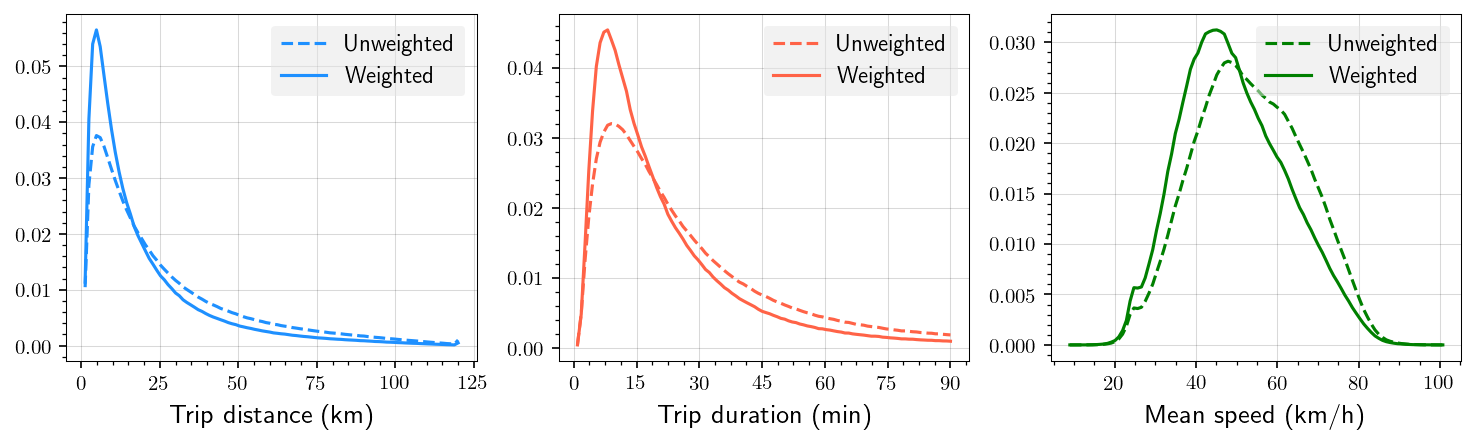

In [47]:
_, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=150)
for i, col, vmax, label, color, ylog in [
        (0, 'distance', 120, 'Trip distance (km)', 'dodgerblue', 1),
        (1, 'duration', 90, 'Trip duration (min)', 'tomato', 0),
        (2, 'speed', 120, 'Mean speed (km/h)', 'green', 0)]:
    ax = pplot(axes[i], xlab=label)
    if col == 'duration': ax.set_xticks(np.arange(0, 91, 15))
    y, x = np.histogram(od[col].clip(0, vmax), 100, density=True)
    ax.plot(x[1:], y, color=color, ls='--', label='Unweighted')
    y, x = np.histogram(od[col].clip(0, vmax), 100, density=True, weights=od.visitors)
    ax.plot(x[1:], y, color=color, label='Weighted')
    ax.legend(loc='upper right')

## NHTS

In [12]:
with open('../data/nhts/nhts-codes.yaml', 'r') as f:
    nhts_codes = yaml.safe_load(f)

In [14]:
tripUS = pd.read_csv('../data/nhts/trippub.csv')
tripUS = (tripUS.assign(weekend=tripUS.TDWKND == 1)
        .assign(mode=tripUS.TRPTRANS.map(nhts_codes['mode']).str.lower())
        .assign(purpose=tripUS.TRIPPURP.map(nhts_codes['purpose']))
        .rename(columns=D(TRVLCMIN='duration', TRPMILES='distance'))
        .query('duration > 0 & distance > 0 & purpose != "Not Home-Based"')
        ['mode purpose duration distance'.split()]
        .dropna().reset_index(drop=1)).disp()

606,146 rows x 4 cols; Memory: 84.4 MiB


,mode,purpose,duration,distance
,<object>,<object>,<int64>,<float64>
0,drive,Other Services,15,5.244


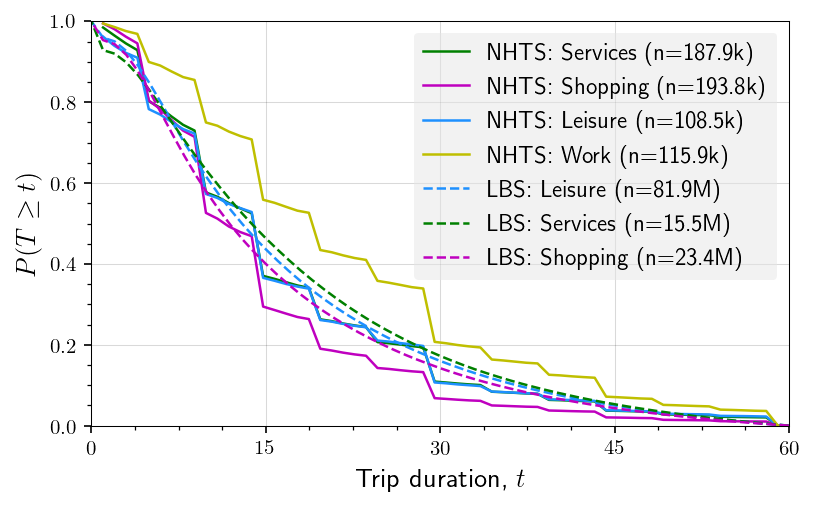

In [47]:
def plot(od=od, trips=tripUS, size=(6, 3.5), dpi=150):
    ax = pplot(size=size, dpi=dpi, ylab=r'$P(T\ge t)$',
               xlim=(0, 60), ylim=(0, 1))
    od = od.assign(time=od.duration // 60)
    od = od.groupby(['time', 'purpose'])['visitors'].sum()
    od = od.reset_index().sort_values('time', ascending=False)
    colors = D(Leisure='dodgerblue', Services='g', Shopping='m', Work='y')
    for purpose, df in trips.groupby('purpose'):
        if purpose == 'Social/Recreational': purpose = 'Leisure'
        if purpose == 'Other Services': purpose = 'Services'
        y, x = np.histogram(df[df.duration <= 61].duration, bins=61)
        y = 1 - (y / y.sum()).cumsum()
        n = len(df) / 1e3
        ax.plot(x[:-1], y, label=f'NHTS: {purpose} (n={n:.1f}k)',
                color=colors[purpose], lw=1.2)
    for purpose, df in od.groupby('purpose'):
        if purpose == 'Overall': continue
        y = df.set_index('time').visitors
        y = (y / y.sum()).cumsum()
        n = df.visitors.sum() / 1e6
        y.plot(ax=ax, label=f'LBS: {purpose} (n={n:.1f}M)',
               color=colors[purpose], ls='--', lw=1.2)
    ax.legend()
    ax.set_xticks(np.arange(0, 61, 15))
    ax.set_xlabel(r'Trip duration, $t$')

plot()